In [42]:
import sys
import os
import pandas as pd

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(notebook_dir, "..")))

In [56]:
import json 

from stats.common import player_roles
from stats.usage import player_usage

usage_frame = player_usage.get_frame({'side': 'off', 'range': 0})

analysis = {
    'qb1': [
        'passAtt',
        'passCmp',
        'passYds',
        'passTd',
        'passInt',
        'fumblesLost'
    ],
    'rb1': {
        'rushAtt',
        'rushYds',
        'rushTd',
        'fumblesLost'
    },
    'wr1': {
        'recAtt',
        'recCmp',
        'recYds',
        'recTd',
        'fumblesLost'
    },
    'wr2': {
        'recAtt',
        'recCmp',
        'recYds',
        'recTd',
        'fumblesLost'
    }
}

for role, stats in analysis.items():
    role_frame = usage_frame[usage_frame['role'] == role]

    for stat in stats:
        rating = role_frame[stat]

        print(f"==={role}:{stat}===")
        print(json.dumps({
            'max': rating.max(),
            'min': rating.min(),
            'mean': rating.mean(),
            'std': rating.std()
        }, indent=4))

===qb1:passAtt===
{
    "max": 68.0,
    "min": 0.0,
    "mean": 33.21009708737864,
    "std": 9.202187954419697
}
===qb1:passCmp===
{
    "max": 45.0,
    "min": 0.0,
    "mean": 21.31883495145631,
    "std": 6.514374100278107
}
===qb1:passYds===
{
    "max": 525.0,
    "min": 0.0,
    "mean": 238.38155339805826,
    "std": 80.24691121821846
}
===qb1:passTd===
{
    "max": 7.0,
    "min": 0.0,
    "mean": 1.47747572815534,
    "std": 1.1635433843717262
}
===qb1:passInt===
{
    "max": 6.0,
    "min": 0.0,
    "mean": 0.7479611650485437,
    "std": 0.8948237665407908
}
===qb1:fumblesLost===
{
    "max": 4.0,
    "min": 0.0,
    "mean": 0.21359223300970873,
    "std": 0.46452069946031105
}
===rb1:rushYds===
{
    "max": 255.0,
    "min": -6.0,
    "mean": 62.416699029126214,
    "std": 37.588654223992215
}
===rb1:rushTd===
{
    "max": 6.0,
    "min": 0.0,
    "mean": 0.4654368932038835,
    "std": 0.6882962670332757
}
===rb1:rushAtt===
{
    "max": 38.0,
    "min": 0.0,
    "mean": 14.

In [ ]:


from stats.games import raw_games
from stats.rating import player_ratings

raw_frame = raw_games.get_frame()

agg = {}
miss = {}
miss_count = {}
df_source = []

for stat in player_roles:
    agg[stat] = 0
    miss[stat] = 0
    miss_count[stat] = 0

for index, row in raw_frame.iterrows():
    home_df_source = {}
    home = player_ratings.access_week({
        'season': row["season"], 
        'week': row["week"], 
        'team': row["homeTeamDisplay"],
        'range': 0,
        'side': 'off'
    }).set_index('role')

    away_df_source = {}
    away = player_ratings.access_week({
        'season': row["season"], 
        'week': row["week"], 
        'team': row["awayTeamDisplay"],
        'range': 0,
        'side': 'off'
    }).set_index('role')

    home_win = row["homeScore"] > row["awayScore"]
    for stat in player_roles:
        home_df_source[stat] = home.loc[stat]['rating']
        away_df_source[stat] = away.loc[stat]['rating']

        if home.loc[stat]['rating'] > away.loc[stat]['rating']:
            if home_win:
                # TP
                agg[stat] += 1
            else:
                # FP
                miss_count[stat] += 1
                miss[stat] = home.loc[stat]['rating'] - away.loc[stat]['rating']
        else:
            if not home_win:
                # TN
                agg[stat] += 1
            else:
                # FN
                miss_count[stat] += 1
                miss[stat] = away.loc[stat]['rating'] - home.loc[stat]['rating']

    df_source.append(home_df_source)
    df_source.append(away_df_source)

for stat in player_roles:
    agg[stat] = agg[stat] / len(raw_games.get_frame().index)

for stat in player_roles:
    miss[stat] = miss[stat] / miss_count[stat]

print(json.dumps(agg, indent=4))
print(json.dumps(miss, indent=4))

ratings = pd.DataFrame(df_source)

{
    "qb1": 0.7759223300970873,
    "wr1": 0.5844660194174758,
    "wr2": 0.5879611650485437,
    "wr3": 0.5584466019417476,
    "rb1": 0.6679611650485436,
    "rb2": 0.5833009708737864,
    "passing": 0.7941747572815534,
    "receiving": 0.5992233009708738,
    "rushing": 0.625242718446602,
    "team": 0.7398058252427184
}
{
    "qb1": 0.02099592108257618,
    "wr1": 0.020594125500667568,
    "wr2": 0.023589605493469754,
    "wr3": 0.00626649076517151,
    "rb1": 0.011418128654970763,
    "rb2": 0.001491146318732527,
    "passing": 0.0029205784948197304,
    "receiving": 0.045343868018286625,
    "rushing": 0.012343835484182409,
    "team": 0.023510517694823204
}


In [44]:
ratings

,qb1,wr1,wr2,wr3,rb1,rb2,passing,receiving,rushing,team
0,74.062500,81.154762,92.166667,78.761905,117.688889,29.800000,74.062500,180.148841,102.624138,370.024476
1,87.245161,83.948718,110.408333,35.714286,107.685088,1.400000,87.500000,157.133333,83.035897,350.538165
2,61.631944,105.476190,47.777778,73.333333,37.241667,54.341667,70.889640,167.011586,63.583333,301.484559
3,178.483333,91.809524,123.466667,126.666667,57.233333,95.600000,154.583333,290.327381,141.540860,585.737289
4,68.574684,56.000000,0.000000,28.800000,34.433333,46.408333,61.426768,114.869048,66.700000,258.585101
...,...,...,...,...,...,...,...,...,...,...
5145,70.946296,65.916667,31.500000,50.566667,49.710256,21.600000,70.254630,159.562500,93.052381,325.832660
5146,92.531863,167.106061,79.000000,39.333333,88.666667,35.985417,90.073529,234.595238,83.500000,419.506607
5147,77.083333,119.384615,118.347222,46.458333,34.441667,0.000000,77.083333,259.822695,16.675000,435.258654
5148,96.854487,57.416667,74.400000,73.333333,176.516667,55.366667,83.012821,132.000000,170.694872,400.998416


In [45]:
print(json.dumps({
    'max': ratings['team'].max(),
    'min': ratings['team'].min(),
    'mean': ratings['team'].mean(),
    'std': ratings['team'].std()
}, indent=4))


{
    "max": 764.8060908084165,
    "min": 94.73371212121212,
    "mean": 402.86723527084604,
    "std": 83.0278118504959
}


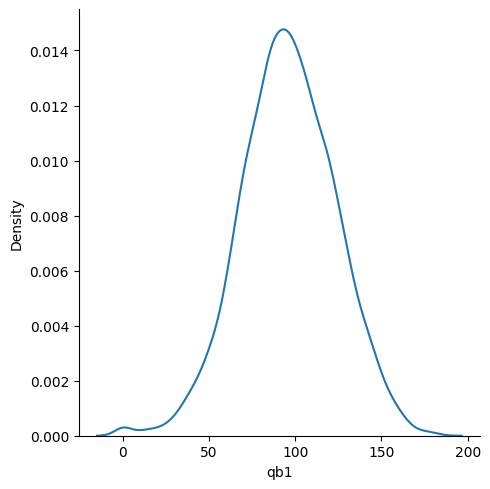

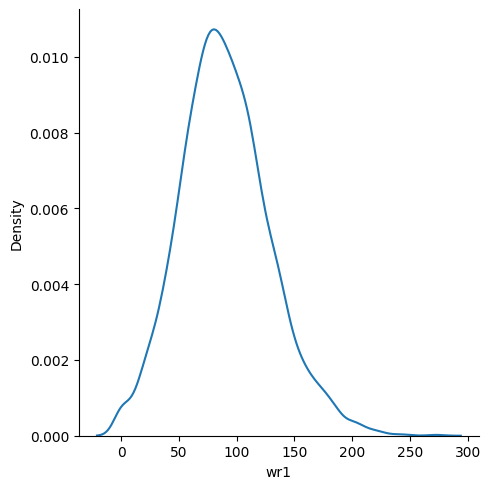

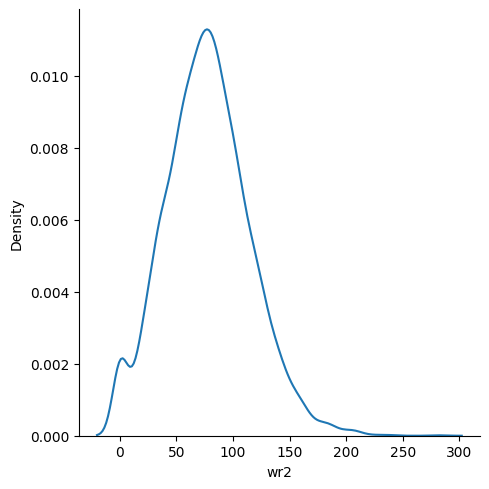

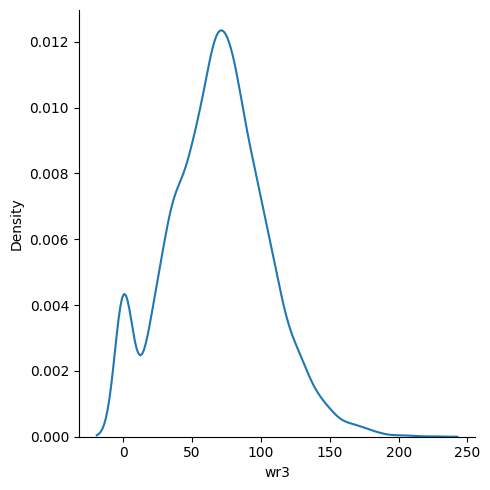

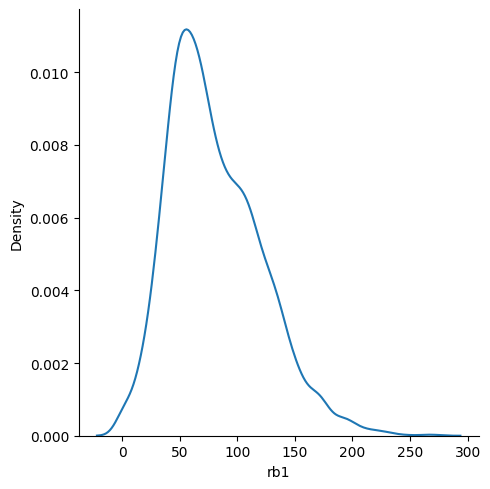

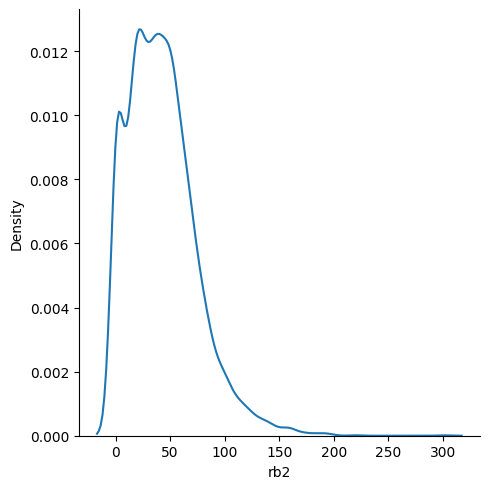

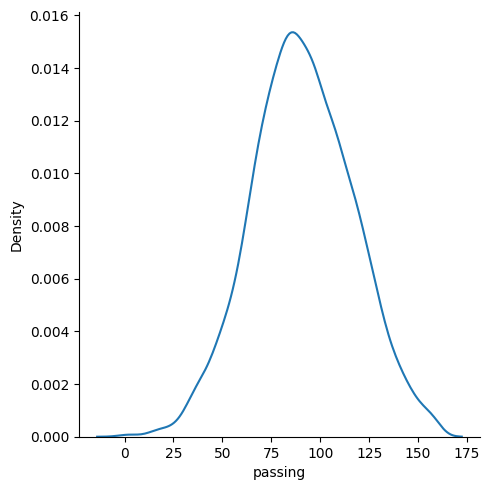

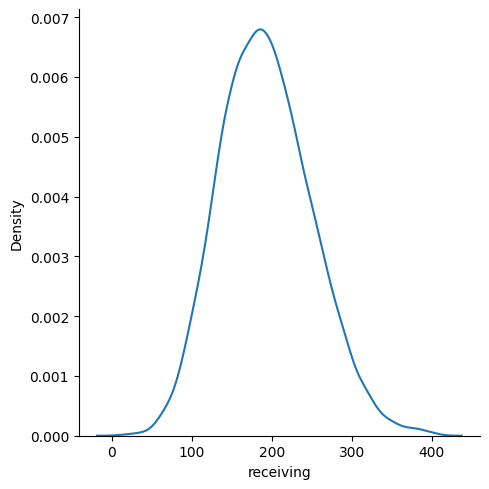

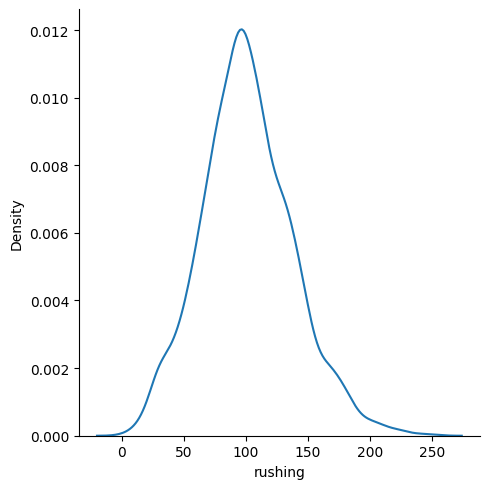

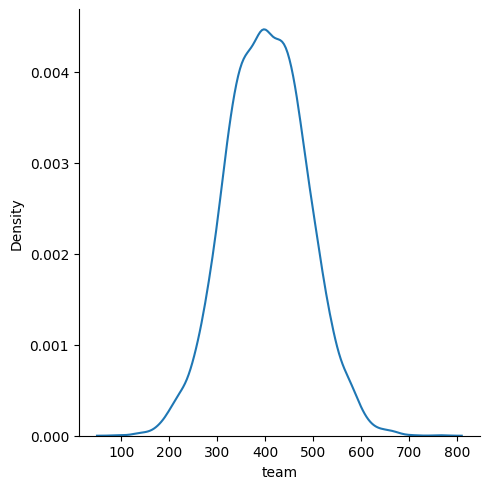

In [47]:
import numpy as np
import seaborn as sbn

for role in player_roles:
    sbn.displot(data=ratings, x=role, kind="kde")